In [16]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math

In [17]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
output_dir = "./dist_out"

In [19]:
train_settings = {
    "Baseline_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": None, "factor": 1},
    "Baseline_1": {"epochs": 4, "lr": 0.001, "l2": 1e-4, "loss_type": None, "factor": 1},
    "Baseline_2": {"epochs": 4, "lr": 0.0008, "l2": 1e-4, "loss_type": None, "factor": 1},
    "Distribution_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution", "factor": 1},
    "Distribution_1": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution", "factor": 4},
    "Distribution_3": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution", "factor": 8},
    "Distribution_v2_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution_v2", "factor": 40},
    "Distribution_v2_1": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution_v2", "factor": 20},
    "Distribution_v2_2": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution_v2", "factor": 100},
}

## Data Loader

In [20]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [21]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [22]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [23]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [24]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

## Eval

In [25]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [26]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * 10 * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.title(f'Accuracy per Mini-Batch for base line')
    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

## Train

In [27]:
def train(model, task_num, criterion, prev_model, epoches = 4, lr = 0.001, l2 = None, loss_type = None, factor = 1):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    if l2 is None:
        optimizer_F = torch.optim.Adam(follower.parameters(), lr)
    else:
        optimizer_F = torch.optim.Adam(follower.parameters(), lr, weight_decay = l2)
        
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            reg_loss = 0
            if (loss_type == "distribution"):
                except_mean = 0.1
                for task in range (10):
                    task_start = task
                    task_end = (task + 1)

                    fake_image = torch.randn(batch_size, 1, 28, 28).to(device)
                    fake_image = (fake_image - 0.5) / 0.5
                    fake_output = follower(fake_image)

                    real_mean = torch.mean(torch.abs(fake_output[:,task_start:task_end]))
                    reg_loss += torch.abs(except_mean - real_mean)
            
            if (loss_type == "distribution_v2"):
                random_data = torch.rand(batch_size, 1, 28, 28).to(device)
                random_data = (random_data - 0.5) / 0.5
                random_target = torch.randint(0, 10, (batch_size,), dtype=torch.int64).to(device)
                fake_output = follower(random_data)
                reg_loss = criterion(fake_output, random_target)
            

            loss = criterion(outputs[:,:valid_out_dim], labels) + factor * reg_loss
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                log_message = []
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    log_message.append(f"Batch num: {batch_num}, Task {task} acc: {acc * 100:.4f}")

                logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1
    
    return follower, task_accuracies

In [28]:
def setup_logging(task_name, epochs, lr, factor, l2):
    log_filename = f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.log"
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(log_filename),
                            logging.StreamHandler()
                        ],
                        force=True)
    
def train_split_task(task_name):
    print(f"Training on {task_name}")
    prev_model = []
    model = MLP_Enhance()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    settings = train_settings[task_name]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']


    if os.path.exists(f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.log") == False:
        setup_logging(task_name, epochs, lr, factor, l2)
        all_accuracies = []
        for task in [0, 1, 2, 3, 4]:
            model, task_accuracies = train(model, task, criterion, prev_model, epoches = epochs, lr = lr, l2 = l2, loss_type = loss_type, factor = factor)
            all_accuracies.append(task_accuracies)
            prev_model.append(model)

        plot_task_acc_history(all_accuracies, f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png", epochs)

## Plot

2024-05-27 15:09:27,721 - INFO - ##########Task 0##########
2024-05-27 15:09:27,722 - INFO - Epoch 0


Training on Baseline_0
Training on Baseline_1
Training on Baseline_2
Training on Distribution_0
Training on Distribution_1
Training on Distribution_3
Training on Distribution_v2_0
Training on Distribution_v2_1


2024-05-27 15:09:30,100 - INFO - Batch num: 0, Task 0 acc: 28.7707, Task avg acc:28.7707
2024-05-27 15:09:32,593 - INFO - Batch num: 10, Task 0 acc: 73.0708, Task avg acc:73.0708
2024-05-27 15:09:35,073 - INFO - Batch num: 20, Task 0 acc: 84.5902, Task avg acc:84.5902
2024-05-27 15:09:37,596 - INFO - Batch num: 30, Task 0 acc: 91.1910, Task avg acc:91.1910
2024-05-27 15:09:40,073 - INFO - Batch num: 40, Task 0 acc: 93.5985, Task avg acc:93.5985
2024-05-27 15:09:42,556 - INFO - Batch num: 50, Task 0 acc: 95.0415, Task avg acc:95.0415
2024-05-27 15:09:45,038 - INFO - Batch num: 60, Task 0 acc: 95.8945, Task avg acc:95.8945
2024-05-27 15:09:47,557 - INFO - Batch num: 70, Task 0 acc: 96.1575, Task avg acc:96.1575
2024-05-27 15:09:50,037 - INFO - Batch num: 80, Task 0 acc: 96.0300, Task avg acc:96.0300
2024-05-27 15:09:52,556 - INFO - Batch num: 90, Task 0 acc: 96.2213, Task avg acc:96.2213
2024-05-27 15:09:52,743 - INFO - Epoch 1
2024-05-27 15:09:54,983 - INFO - Batch num: 0, Task 0 acc: 9

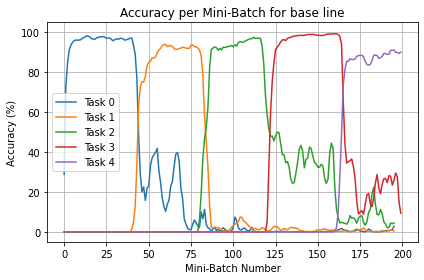

2024-05-27 15:51:28,793 - INFO - ##########Task 0##########
2024-05-27 15:51:28,794 - INFO - Epoch 0


Training on Distribution_v2_2


2024-05-27 15:51:31,009 - INFO - Batch num: 0, Task 0 acc: 0.0080, Task avg acc:0.0080
2024-05-27 15:51:33,445 - INFO - Batch num: 10, Task 0 acc: 12.9066, Task avg acc:12.9066
2024-05-27 15:51:35,839 - INFO - Batch num: 20, Task 0 acc: 20.5437, Task avg acc:20.5437
2024-05-27 15:51:38,246 - INFO - Batch num: 30, Task 0 acc: 21.8351, Task avg acc:21.8351
2024-05-27 15:51:40,627 - INFO - Batch num: 40, Task 0 acc: 38.7038, Task avg acc:38.7038
2024-05-27 15:51:43,033 - INFO - Batch num: 50, Task 0 acc: 49.8565, Task avg acc:49.8565
2024-05-27 15:51:45,460 - INFO - Batch num: 60, Task 0 acc: 45.7749, Task avg acc:45.7749
2024-05-27 15:51:47,844 - INFO - Batch num: 70, Task 0 acc: 39.3495, Task avg acc:39.3495
2024-05-27 15:51:50,227 - INFO - Batch num: 80, Task 0 acc: 49.8485, Task avg acc:49.8485
2024-05-27 15:51:52,615 - INFO - Batch num: 90, Task 0 acc: 57.6929, Task avg acc:57.6929
2024-05-27 15:51:52,796 - INFO - Epoch 1
2024-05-27 15:51:54,951 - INFO - Batch num: 0, Task 0 acc: 62.

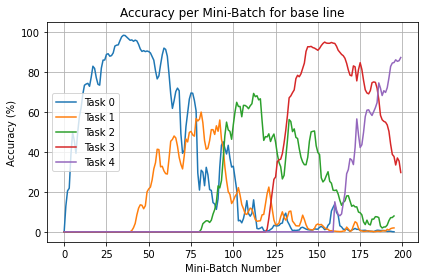

In [29]:
for key in train_settings.keys():
    train_split_task(key)

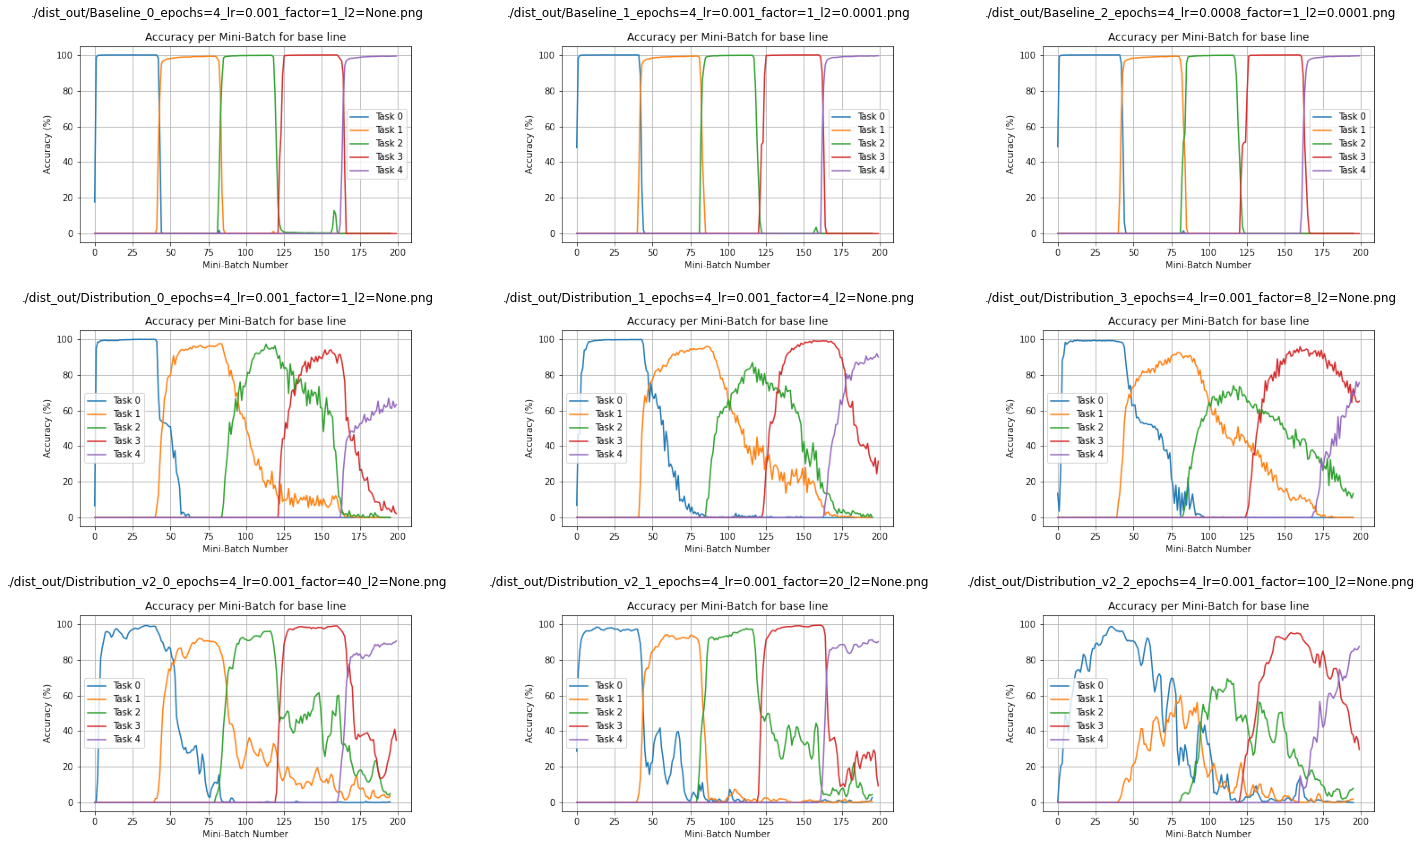

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
import math

ncols = 3
nrows = math.ceil(len(train_settings.keys()) / 3.)

plt.figure(figsize=(21, 4 * nrows))  # Adjust the figure size based on the number of rows
for i, key in enumerate(train_settings.keys()):
    plt.subplot(nrows, ncols, i + 1)

    settings = train_settings[key]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']

    file_name = f"{output_dir}/{key}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png"
    try:
        with Image.open(file_name) as img:
            plt.imshow(img)
            plt.title(f'{file_name}')
            plt.axis('off')
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist.")
plt.tight_layout()
plt.show()  # Move plt.show() outside the loop to display all subplots at once
